Tesseract Overview
-----------------------

This notebook is supposed to provide a brief overview over the Tesseract framework (and might be later adapted to Transcend as well).


    ├── tesseract             <- Main folder
    │   ├── mock.py           <- Module for generating test distributions for use with Tesseract
    │   ├── evaluation.py     <- This is the class where the magic happens  ;)
    │   ├── metrics.py        <- Various methods to calculate and output metrics (including AUT)
    │   └── ...

**TODO**: Extend this description

---

In [7]:
import os
import json
import numpy as np
from datetime import datetime
from sklearn.feature_extraction import DictVectorizer

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_PATH = os.path.join(PROJ_ROOT, 'data', 'processed')

features_file, labels_file, meta_file = os.path.join(PATH, 'drebin-parrot-v2-down-features-X.json'), os.path.join(PATH, 'drebin-parrot-v2-down-features-Y.json'), os.path.join(PATH, 'drebin-parrot-v2-down-features-meta.json')

with open(features_file) as json_file:
    D = json.load(json_file)
    for datapoint in D:
        del datapoint['sha256']
    vec = DictVectorizer()
    X = vec.fit_transform(D)
    
with open(labels_file) as json_file:
    labels = json.load(json_file)
    y = np.array([l[0] for l in labels])
    
with open(meta_file) as json_file:
    meta = json.load(json_file)
    t = list()
    for m in meta:
        timestamp = datetime.strptime(m['dex_date'], '%Y-%m-%dT%H:%M:%S')
        t.append(timestamp)
    t = np.array(t)

In [8]:
from tesseract import evaluation, temporal, metrics, mock

# Partition dataset
splits = temporal.time_aware_train_test_split(X, y, t, train_size=12, test_size=1, granularity='month')

In [9]:
from sklearn.svm import LinearSVC

# Perform a timeline evaluation
clf = LinearSVC()
results = evaluation.fit_predict_update(clf, *splits)
    
# View results 
metrics.print_metrics(results)
    
# View AUT(F1, 24 months) as a measure of robustness over time 
print(metrics.aut(results, 'f1'))

0it [00:00, ?it/s]/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
1it [00:05,  5.12s/it]/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
2it [00:09,  4.85s/it]/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
3it [00:14,  4.72s/it]/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
4it [00:18,  4.65s/it]/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
5it [00:23,  4.65s/it]/usr/local/lib/python3.9/site-pa

------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Test period |     1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20     21     22     23     24   
------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Actual pos  |    144    129    215    183    221    216    275    272    354    313    374    369    344    476    635    612    452    278    352    564    148     81     23      8
Actual neg  |   1564   1231   1888   1838   1953   2098   2521   2768   3077   2932   3010   3289   3478   3959   5818   6368   4052   2806   3027   4881   1377    758    190     67
Total       |   1708   1360   2103   2021   2174   2314   2796   3040   3431   3245   33

0.5761775829417267


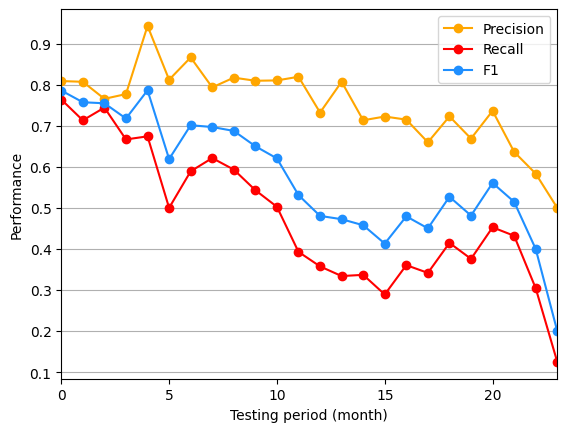

In [10]:
print(metrics.aut(results, 'f1'))
#%%
from pylab import *

pendleblue='#1f8fff'
pendleyellow='#ffa600'

'#FF9999', '#FFDD99', '#AAEEEE'
plot(results['precision'], marker='o', color=pendleyellow)
plot(results['recall'], marker='o', color='red')
plot(results['f1'], marker='o', color=pendleblue)
legend(['Precision', 'Recall', 'F1'])
xlim([0,23])
xlabel('Testing period (month)')
ylabel('Performance')
grid(axis = 'y')